# Single label Classifier - AF Detection

Using the dataset provided by the 2020 Physionet Challenge we've developed an Atrial Fibrilation Detector trained to identify AF diagnosed patiences from a dataset containing patiances with different pathologies like: PAC, RBBB, I-AVB, PVC, LBBB, STD, STE and healthy individuals.

Although data from 12-lead ECG was provided, for this first analysis we've only used the lead 2 data and we've processed the signals in order to create a dataframe consisting of features we believe will help us classify.


In [130]:
import sys
import os

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy

from xverse.transformer import WOE

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from IPython.display import display

from scipy.cluster import hierarchy as hc
from sklearn import metrics
from sklearn.metrics import f1_score, fbeta_score, make_scorer, confusion_matrix
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA, KernelPCA

import mlflow
import mlflow.sklearn

%matplotlib inline
import plotly.express as px
import seaborn as sns

## Now we can choose which lead data to load

### Lead 2 data seems to give better results:

In [131]:
ls datasets

phys-raw-lead2-HRV-corrected


In [132]:
lead = 'HRV-lead2'
df_raw = pd.read_feather('datasets/phys-raw-lead2-HRV-corrected')
df_raw.columns

Index(['HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN',
       'HRV_pNN50', 'HRV_pNN20', 'HRV_TINN', 'HRV_HTI', 'mean_P_Peaks', 'age',
       'label'],
      dtype='object')

In [133]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

,AF,I-AVB,LBBB,Normal,PAC,PVC,RBBB,STD,STE
count,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000
mean,0.177548,0.104988,0.028937,0.133488,0.079104,0.091173,0.243566,0.114294,0.026901
std,0.382160,0.306560,0.167642,0.340127,0.269921,0.287877,0.429265,0.318191,0.161807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [134]:
df_raw = df_raw.loc[df_raw['age'] >= 0]

## Removing Redundant Features

By calculating a Dendrogram we look for features that may be providing the same information so we can remove them and end up with a cleaner model.

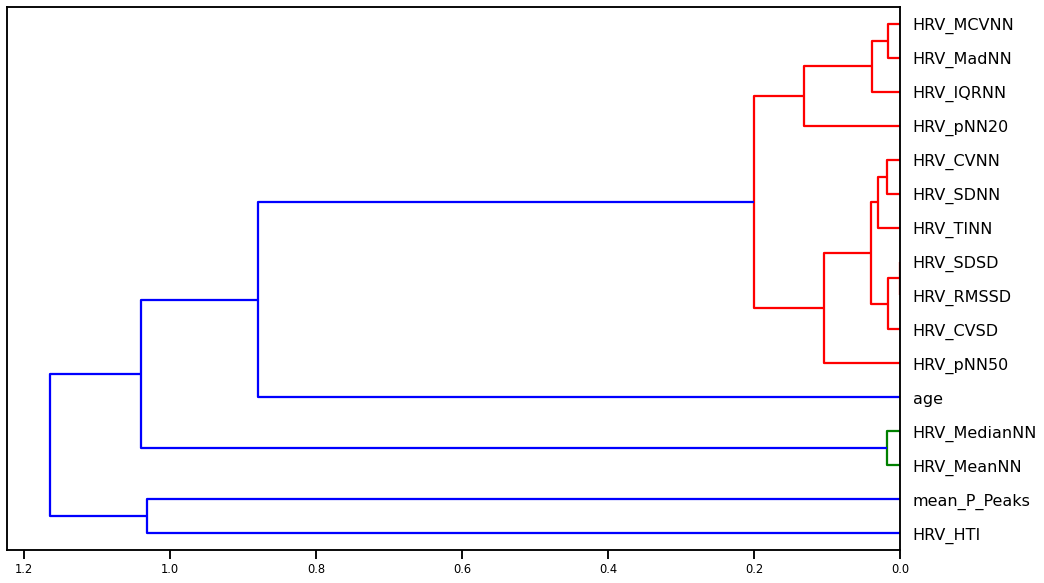

In [135]:
corr = np.round(scipy.stats.spearmanr(df_raw.drop('label',axis=1)).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_raw.drop('label',axis=1).columns, orientation='left', leaf_font_size=16)
plt.show()

Given that the variance can be obtained from the std, and viceversa it's no surprise they seem to provide the same information. Let's try and remove them.

In [136]:
to_drop = ['HRV_SDSD']
df_raw = df_raw.drop(to_drop, axis=1)

<AxesSubplot:>

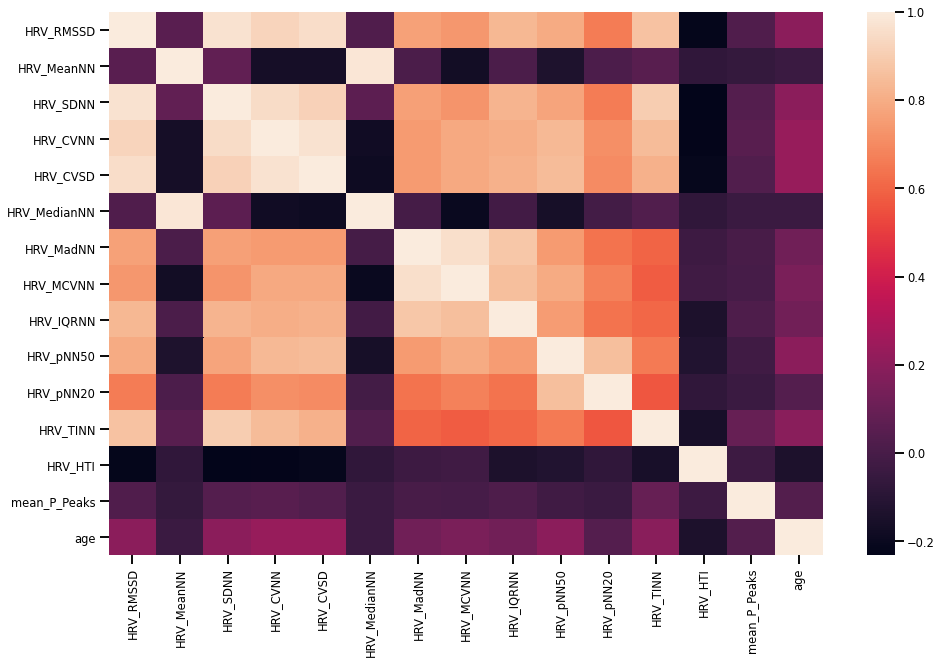

In [137]:
plt.figure(figsize=(16,10))
sns.heatmap(df_raw.corr())

### Renaming everything else as "Non-AF" in both sets

In [138]:
df_raw.loc[df_raw.label != 'AF', 'label'] = 'Non-AF'

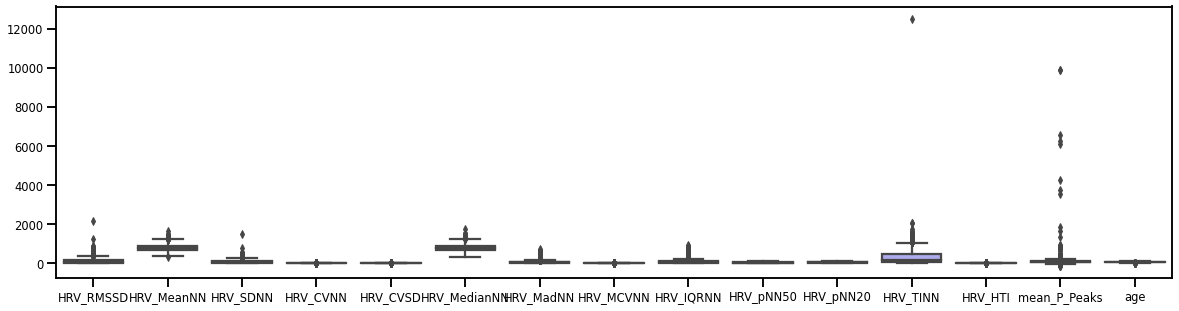

In [139]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df_raw)
plt.show()

Seems to be an outlier so we'll remove that one from our dataset

In [377]:
df_raw = df_raw.drop(df_raw.loc[df_raw.HRV_TINN > 12000,'HRV_TINN'].index)
df_raw = df_raw.drop(df_raw.loc[df_raw.mean_P_Peaks > 1000,'mean_P_Peaks'].index)

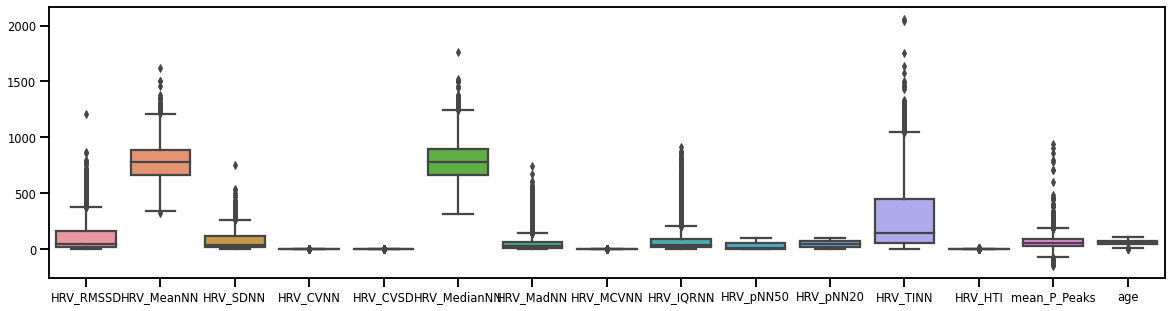

In [142]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df_raw)
plt.show()

<Figure size 2160x720 with 0 Axes>

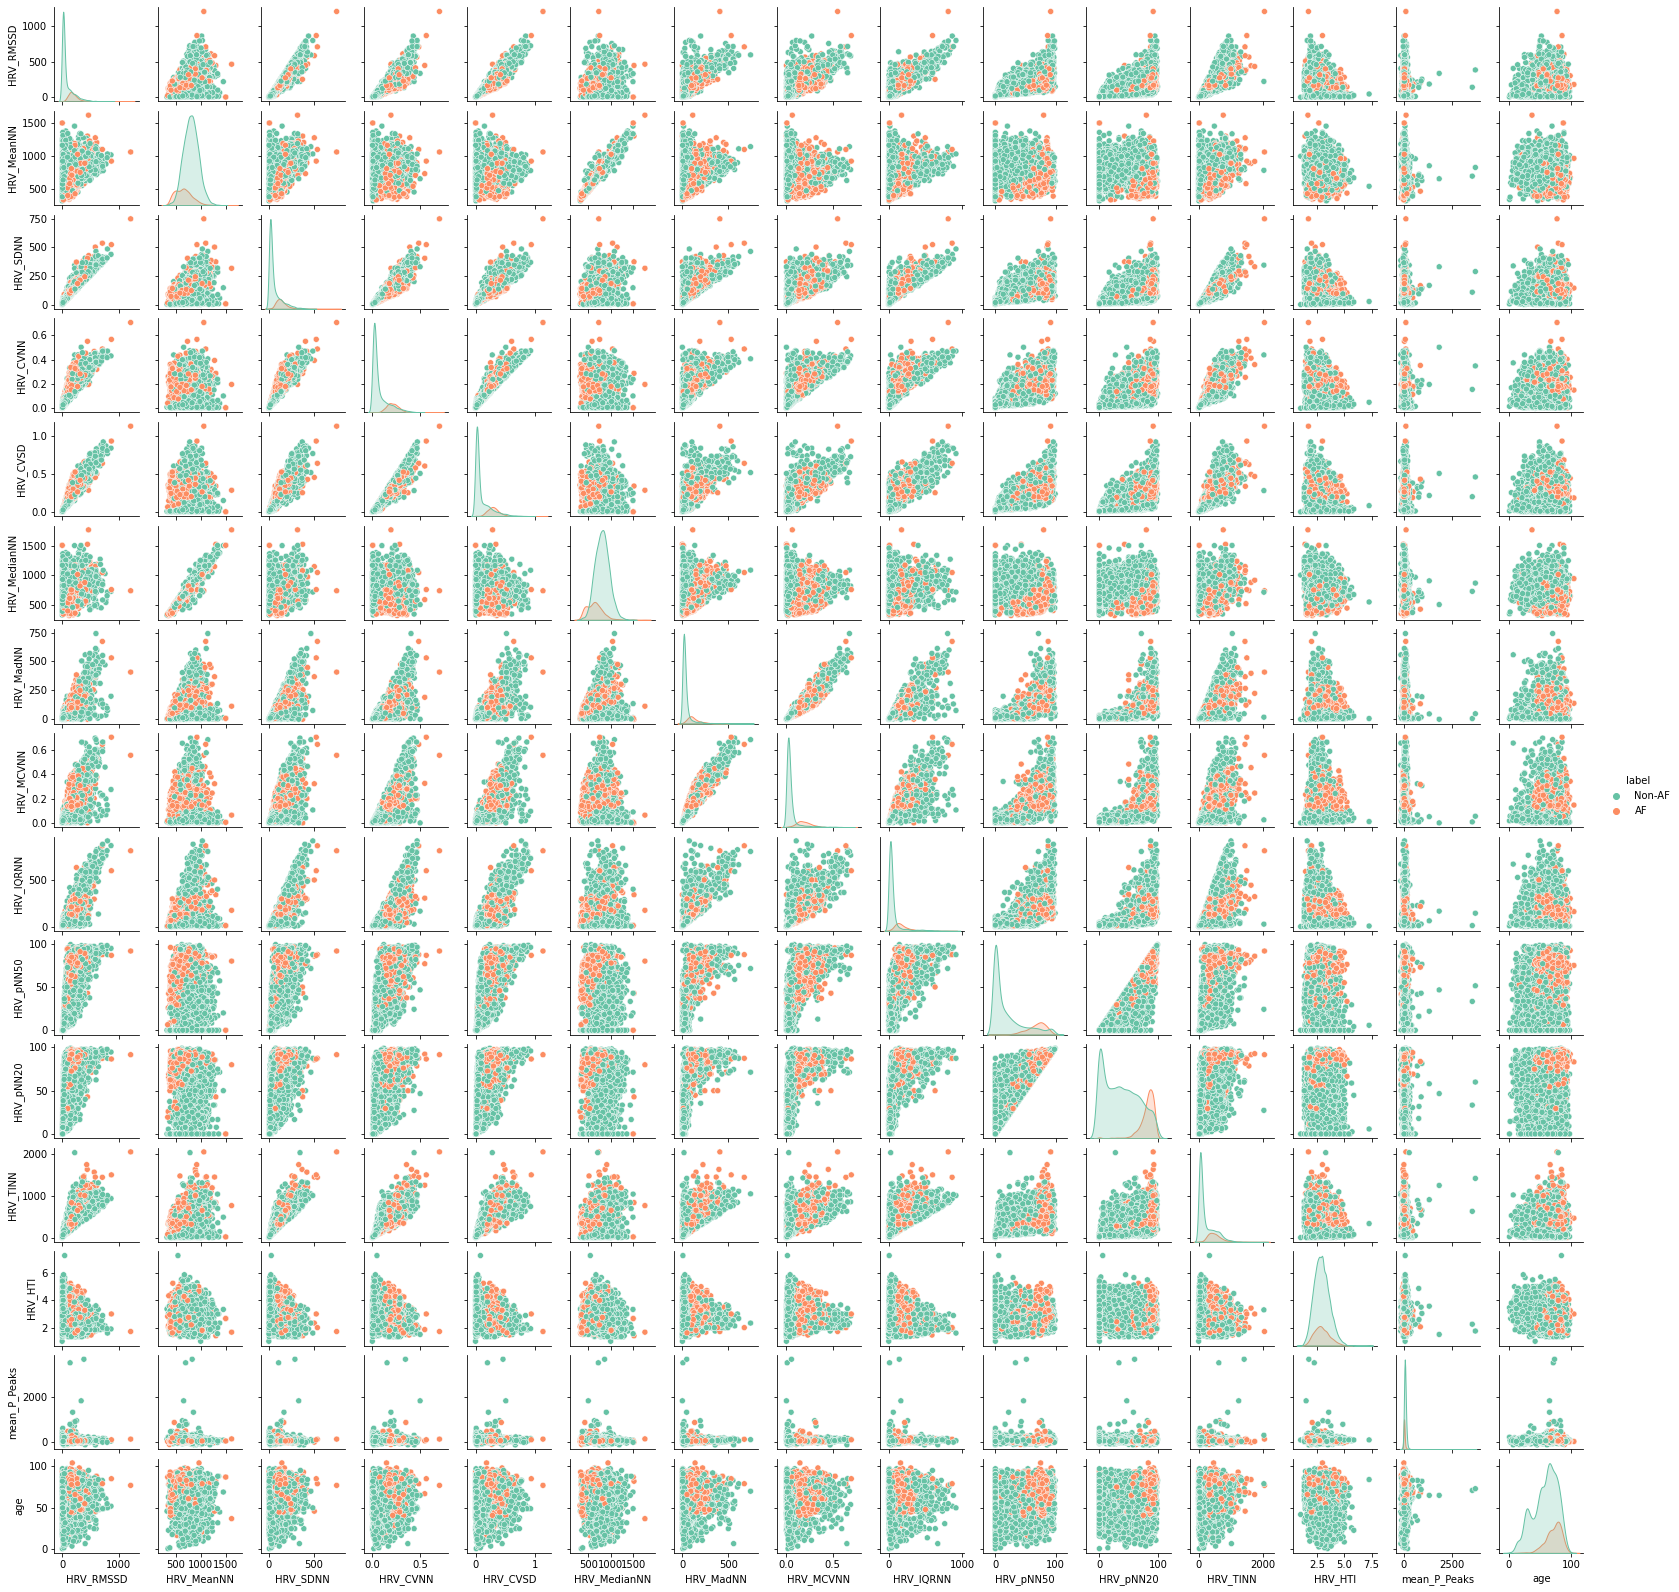

In [14]:
plt.figure(figsize=(30,10))
sns.pairplot(data=df_raw, hue='label', palette='Set2', height=1.5)
plt.show()

## Split between Train and Validation Datasets

### Training Set (80%) - Validation (20%)

In [318]:
y = df_raw['label']
X = df_raw.drop('label', axis=1)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)

## We check for missing values

In [319]:
df_raw.isnull().sum()

HRV_RMSSD       0
HRV_MeanNN      0
HRV_SDNN        0
HRV_CVNN        0
HRV_CVSD        0
HRV_MedianNN    0
HRV_MadNN       0
HRV_MCVNN       0
HRV_IQRNN       0
HRV_pNN50       0
HRV_pNN20       0
HRV_TINN        0
HRV_HTI         0
mean_P_Peaks    0
age             0
label           0
dtype: int64

## Evaluation Metrics

This are the evaluation metrics we are actually interested in.

In [320]:
res = pd.DataFrame({'model':[], 'f1':[]})

### We process our datasets and train our model

In [321]:
lr = LogisticRegression(n_jobs=4)

%time lr.fit(X_train, y_train)

f1_score(y_eval, lr.predict(X_eval), pos_label='AF')

CPU times: user 15.4 ms, sys: 3.02 ms, total: 18.4 ms
Wall time: 212 ms


0.8508946322067595

In [322]:
res = res.append({'model':'Logistic Regression',
                  'f1': f1_score(y_eval, lr.predict(X_eval), pos_label='AF')}, ignore_index=True)

In [323]:
rf = RandomForestClassifier(n_jobs=4)

%time rf.fit(X_train, y_train)

f1_score(y_eval, rf.predict(X_eval), pos_label='AF')

CPU times: user 962 ms, sys: 214 ms, total: 1.18 s
Wall time: 367 ms


0.9105058365758755

In [324]:
res = res.append({'model':'Random Forest',
                  'f1': f1_score(y_eval, rf.predict(X_eval), pos_label='AF')}, ignore_index=True)

In [325]:
svc = SVC()

%time svc.fit(X_train, y_train)

f1_score(y_eval, svc.predict(X_eval), pos_label='AF')

CPU times: user 306 ms, sys: 0 ns, total: 306 ms
Wall time: 305 ms


0.8771929824561403

In [326]:
res = res.append({'model':'SVC',
                  'f1': f1_score(y_eval, svc.predict(X_eval), pos_label='AF')}, ignore_index=True)

In [327]:
knn = KNeighborsClassifier()

%time knn.fit(X_train, y_train)

f1_score(y_eval, knn.predict(X_eval), pos_label='AF')

CPU times: user 15.1 ms, sys: 0 ns, total: 15.1 ms
Wall time: 13.9 ms


0.867704280155642

In [328]:
res = res.append({'model':'KNN',
                  'f1': f1_score(y_eval, knn.predict(X_eval), pos_label='AF')}, ignore_index=True)

In [329]:
res.sort_values('f1', ascending=False)

,model,f1
1,Random Forest,0.910506
2,SVC,0.877193
3,KNN,0.867704
0,Logistic Regression,0.850895


## Let's try a Standard Scaler

In [330]:
scal = StandardScaler()
xtrain_scal = scal.fit_transform(X_train)
xeval_scal = scal.transform(X_eval)

In [331]:
lr = LogisticRegression(n_jobs=4)

%time lr.fit(xtrain_scal, y_train)

f1_score(y_eval, lr.predict(xeval_scal), pos_label='AF')

CPU times: user 8.14 ms, sys: 15 µs, total: 8.16 ms
Wall time: 119 ms


0.8531746031746033

In [332]:
res = res.append({'model':'Logistic Regression Scal',
                  'f1': f1_score(y_eval, lr.predict(xeval_scal), pos_label='AF')}, ignore_index=True)

In [333]:
rf = RandomForestClassifier(n_jobs=4)

%time rf.fit(xtrain_scal, y_train)

f1_score(y_eval, rf.predict(xeval_scal), pos_label='AF')

CPU times: user 1.23 s, sys: 249 ms, total: 1.48 s
Wall time: 397 ms


0.9066147859922179

In [334]:
res = res.append({'model':'Random Forest Scal',
                  'f1': f1_score(y_eval, rf.predict(xeval_scal), pos_label='AF')}, ignore_index=True)

In [335]:
svc = SVC()

%time svc.fit(xtrain_scal, y_train)

f1_score(y_eval, svc.predict(xeval_scal), pos_label='AF')

CPU times: user 244 ms, sys: 3.49 ms, total: 247 ms
Wall time: 247 ms


0.888888888888889

In [336]:
res = res.append({'model':'SVC Scal',
                  'f1': f1_score(y_eval, svc.predict(xeval_scal), pos_label='AF')}, ignore_index=True)

In [337]:
knn = KNeighborsClassifier()

%time knn.fit(xtrain_scal, y_train)

f1_score(y_eval, knn.predict(xeval_scal), pos_label='AF')

CPU times: user 15.2 ms, sys: 0 ns, total: 15.2 ms
Wall time: 14.1 ms


0.8787878787878787

In [338]:
res = res.append({'model':'KNN Scal',
                  'f1': f1_score(y_eval, knn.predict(xeval_scal), pos_label='AF')}, ignore_index=True)

In [339]:
res.sort_values('f1', ascending=False)

,model,f1
1,Random Forest,0.910506
5,Random Forest Scal,0.906615
6,SVC Scal,0.888889
7,KNN Scal,0.878788
2,SVC,0.877193
3,KNN,0.867704
4,Logistic Regression Scal,0.853175
0,Logistic Regression,0.850895


### Let's check and see if there's a polynomical relation between features

In [340]:
X_train.columns

Index(['HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_CVNN', 'HRV_CVSD',
       'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_TINN', 'HRV_HTI', 'mean_P_Peaks', 'age'],
      dtype='object')

In [341]:
xpol_train = X_train.drop('age', axis=1)
xpol_eval = X_eval.drop('age', axis=1)

poly = PolynomialFeatures(2, include_bias=False)

xtrain_poly = poly.fit_transform(xpol_train)
xeval_poly = poly.transform(xpol_eval)

xtrain_poly = np.c_[xtrain_poly, X_train.age]
xeval_poly = np.c_[xeval_poly, X_eval.age]

scal = StandardScaler()
xtrain_poly = scal.fit_transform(xtrain_poly)
xeval_poly = scal.transform(xeval_poly)

In [342]:
xtrain_poly.shape

(5489, 120)

In [343]:
lr = LogisticRegression(n_jobs=4)

%time lr.fit(xtrain_poly, y_train)

f1_score(y_eval, lr.predict(xeval_poly), pos_label='AF')

CPU times: user 11.4 ms, sys: 0 ns, total: 11.4 ms
Wall time: 1.04 s


0.8949416342412452

In [344]:
res = res.append({'model':'Logistic Regression Poly',
                  'f1': f1_score(y_eval, lr.predict(xeval_poly), pos_label='AF')}, ignore_index=True)

In [345]:
rf = RandomForestClassifier(n_jobs=4)

%time rf.fit(xtrain_poly, y_train)

f1_score(y_eval, rf.predict(xeval_poly), pos_label='AF')

CPU times: user 3.3 s, sys: 289 ms, total: 3.59 s
Wall time: 941 ms


0.9019607843137255

In [346]:
res = res.append({'model':'Random Forest Poly',
                  'f1': f1_score(y_eval, rf.predict(xeval_poly), pos_label='AF')}, ignore_index=True)

In [347]:
svc = SVC()

%time svc.fit(xtrain_poly, y_train)

f1_score(y_eval, svc.predict(xeval_poly), pos_label='AF')

CPU times: user 908 ms, sys: 0 ns, total: 908 ms
Wall time: 906 ms


0.8906249999999999

In [348]:
res = res.append({'model':'SVC Poly',
                  'f1': f1_score(y_eval, svc.predict(xeval_poly), pos_label='AF')}, ignore_index=True)

In [349]:
knn = KNeighborsClassifier(n_jobs=4)

%time knn.fit(xtrain_poly, y_train)

f1_score(y_eval, knn.predict(xeval_poly), pos_label='AF')

CPU times: user 55.3 ms, sys: 0 ns, total: 55.3 ms
Wall time: 53.8 ms


0.8838095238095238

In [350]:
res = res.append({'model':'KNN Poly',
                  'f1': f1_score(y_eval, knn.predict(xeval_poly), pos_label='AF')}, ignore_index=True)

In [351]:
res.sort_values('f1', ascending=False)

,model,f1
1,Random Forest,0.910506
5,Random Forest Scal,0.906615
9,Random Forest Poly,0.901961
8,Logistic Regression Poly,0.894942
10,SVC Poly,0.890625
6,SVC Scal,0.888889
11,KNN Poly,0.883810
7,KNN Scal,0.878788
2,SVC,0.877193
3,KNN,0.867704


## We take a look at Principal Component Analysis

In [352]:
n_comps = X_train.shape[1]

pca = PCA(n_components = n_comps)

train_pca = pca.fit_transform(xtrain_scal)

eval_pca = pca.transform(xeval_scal)

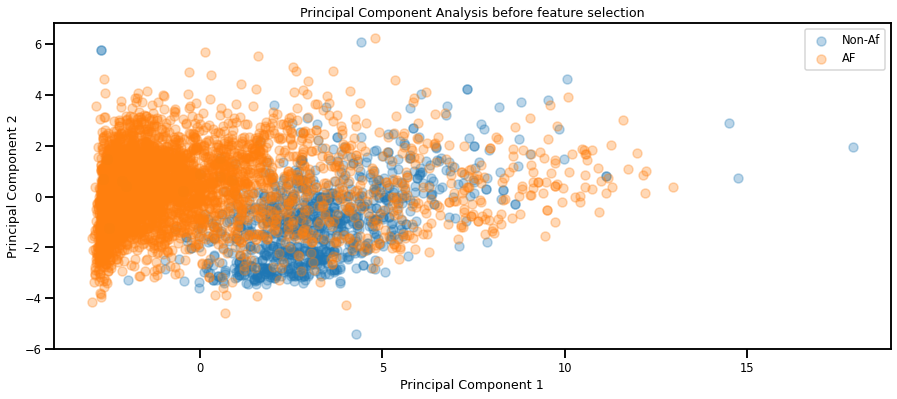

In [353]:
xpca = pd.DataFrame(train_pca)

sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(15,6))
plt.scatter(xpca.loc[(y_train == 'AF').ravel(),0],xpca.loc[(y_train == 'AF').ravel(),1], alpha = 0.3, label = 'Non-Af')
plt.scatter(xpca.loc[(y_train == 'Non-AF').ravel(),0],xpca.loc[(y_train == 'Non-AF').ravel(),1], alpha = 0.3, label = 'AF')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')
plt.show()

In [354]:
lr = LogisticRegression(n_jobs=4)

%time lr.fit(train_pca, y_train)

f1_score(y_eval, lr.predict(eval_pca), pos_label='AF')

CPU times: user 9.59 ms, sys: 322 µs, total: 9.92 ms
Wall time: 157 ms


0.8531746031746033

In [355]:
res = res.append({'model':'Logistic Regression PCA',
                  'f1': f1_score(y_eval, lr.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [356]:
rf = RandomForestClassifier(n_jobs=4)

%time rf.fit(train_pca, y_train)

f1_score(y_eval, rf.predict(eval_pca), pos_label='AF')

CPU times: user 1.75 s, sys: 242 ms, total: 1.99 s
Wall time: 602 ms


0.903353057199211

In [357]:
res = res.append({'model':'Random Forest PCA',
                  'f1': f1_score(y_eval, rf.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [358]:
svc = SVC()

%time svc.fit(train_pca, y_train)

f1_score(y_eval, svc.predict(eval_pca), pos_label='AF')

CPU times: user 334 ms, sys: 0 ns, total: 334 ms
Wall time: 333 ms


0.888888888888889

In [359]:
res = res.append({'model':'SVC PCA',
                  'f1': f1_score(y_eval, svc.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [360]:
knn = KNeighborsClassifier(n_jobs=4)

%time knn.fit(train_pca, y_train)

f1_score(y_eval, knn.predict(eval_pca), pos_label='AF')

CPU times: user 20.2 ms, sys: 0 ns, total: 20.2 ms
Wall time: 18.7 ms


0.8787878787878787

In [361]:
res = res.append({'model':'KNN PCA',
                  'f1': f1_score(y_eval, knn.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [362]:
res.sort_values('f1', ascending=False)

,model,f1
1,Random Forest,0.910506
5,Random Forest Scal,0.906615
13,Random Forest PCA,0.903353
9,Random Forest Poly,0.901961
8,Logistic Regression Poly,0.894942
10,SVC Poly,0.890625
6,SVC Scal,0.888889
14,SVC PCA,0.888889
11,KNN Poly,0.883810
7,KNN Scal,0.878788


## PCA on the polynomial features

In [363]:
n_comps = X_train.shape[1]

pca = PCA(n_components = n_comps)

train_pca = pca.fit_transform(xtrain_poly)

eval_pca = pca.transform(xeval_poly)

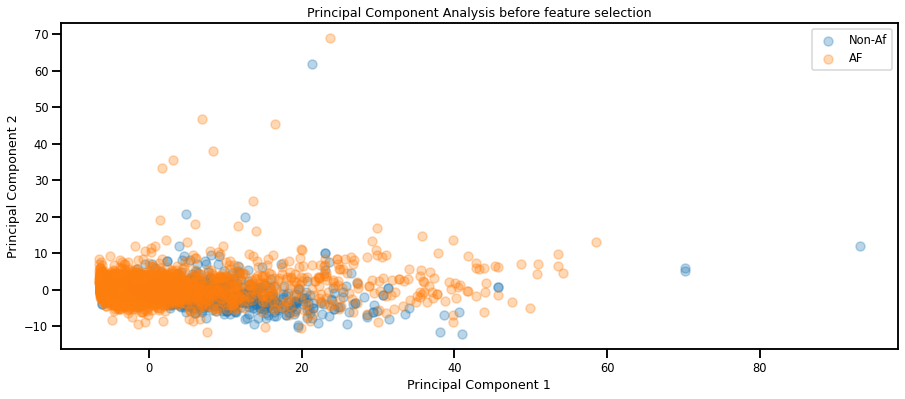

In [364]:
xpca = pd.DataFrame(train_pca)

sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(15,6))
plt.scatter(xpca.loc[(y_train == 'AF').ravel(),0],xpca.loc[(y_train == 'AF').ravel(),1], alpha = 0.3, label = 'Non-Af')
plt.scatter(xpca.loc[(y_train == 'Non-AF').ravel(),0],xpca.loc[(y_train == 'Non-AF').ravel(),1], alpha = 0.3, label = 'AF')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')
plt.show()

In [365]:
lr = LogisticRegression(n_jobs=4)

%time lr.fit(train_pca, y_train)

f1_score(y_eval, lr.predict(eval_pca), pos_label='AF')

CPU times: user 6.91 ms, sys: 13.3 ms, total: 20.2 ms
Wall time: 381 ms


0.8520710059171598

In [366]:
res = res.append({'model':'Logistic Regression PCA Poly',
                  'f1': f1_score(y_eval, lr.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [367]:
rf = RandomForestClassifier(n_jobs=4)

%time rf.fit(train_pca, y_train)

f1_score(y_eval, rf.predict(eval_pca), pos_label='AF')

CPU times: user 2.93 s, sys: 104 ms, total: 3.04 s
Wall time: 929 ms


0.9005847953216374

In [368]:
res = res.append({'model':'Random Forest PCA Poly',
                  'f1': f1_score(y_eval, rf.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [369]:
svc = SVC()

%time svc.fit(train_pca, y_train)

f1_score(y_eval, svc.predict(eval_pca), pos_label='AF')

CPU times: user 553 ms, sys: 0 ns, total: 553 ms
Wall time: 552 ms


0.8871595330739299

In [370]:
res = res.append({'model':'SVC PCA Poly',
                  'f1': f1_score(y_eval, svc.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [371]:
knn = KNeighborsClassifier(n_jobs=4)

%time knn.fit(train_pca, y_train)

f1_score(y_eval, knn.predict(eval_pca), pos_label='AF')

CPU times: user 27.7 ms, sys: 0 ns, total: 27.7 ms
Wall time: 25.4 ms


0.8931297709923665

In [372]:
res = res.append({'model':'KNN PCA Poly',
                  'f1': f1_score(y_eval, knn.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [373]:
res.sort_values('f1', ascending=False)

,model,f1
1,Random Forest,0.910506
5,Random Forest Scal,0.906615
13,Random Forest PCA,0.903353
9,Random Forest Poly,0.901961
17,Random Forest PCA Poly,0.900585
8,Logistic Regression Poly,0.894942
19,KNN PCA Poly,0.893130
10,SVC Poly,0.890625
6,SVC Scal,0.888889
14,SVC PCA,0.888889


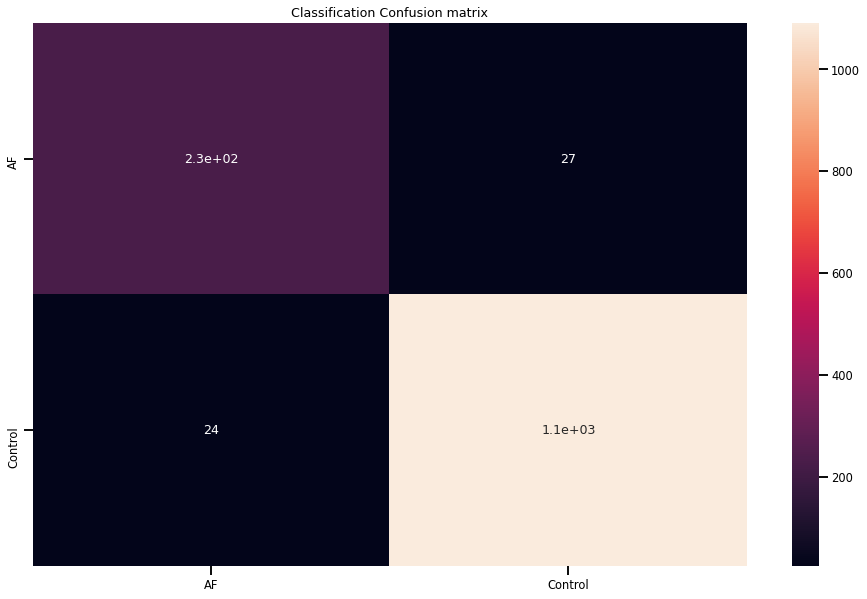

In [374]:
ypred = rf.predict(eval_pca)

cm = confusion_matrix(y_eval, ypred)

df_cm = pd.DataFrame(cm, index = ['AF', 'Control'], columns = ['AF', 'Control'])
plt.figure(figsize = (16,10))
sns.heatmap(df_cm, annot=True)
plt.title('Classification Confusion matrix')
plt.show()

We create a MLFlow experiment in order to keep track of the results

In [375]:
mlflow.set_experiment('AF_feature_testing-' + lead)
with mlflow.start_run() as run:
    mlflow.log_params({'n_estimators': '1000', 'min_samples_leaf': '1', 'max_features': 'sqrt'})
    mlflow.log_param('n_Features', len(list(X_train.columns)))
    mlflow.log_metric('f1_score', f1_score(y_eval, m_af.predict(X_eval), pos_label=0))
    mlflow.log_metric('f2_score', fbeta_score(y_eval, m_af.predict(X_eval), beta=2, pos_label=0))
    

NameError: name 'm_af' is not defined

In [ ]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(X_train_drop, y_train)

print_fscores(m_af, X_eval_drop, y_eval)

In [ ]:
mlflow.set_experiment('AF_feature_testing-' + lead)
with mlflow.start_run() as run:
    mlflow.log_params({'n_estimators': '1000', 'min_samples_leaf': '1', 'max_features': 'sqrt'})
    mlflow.log_param('n_Features', len(list(X_train_drop.columns)))
    mlflow.log_metric('f1_score', f1_score(y_eval, m_af.predict(X_eval_drop), pos_label=0))
    mlflow.log_metric('f2_score', fbeta_score(y_eval, m_af.predict(X_eval_drop), beta=2, pos_label=0))
    

## Looking at Feature Importance

### MDI

We calculate the feature importance using the MDI (Mean Decrease in Impurity) method, with is the default for sklearn's Random Forests

In [ ]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,8), legend=False)

In [ ]:
fi_mdi = rf_feat_importance(m_af, X_train_drop)
plot_fi(fi_mdi);

### MDA

We now calculate feature importance using the MDA (Mean Decrease in Accuracy) method to compare. We can pass our own score algorithm so we will use the beta score since is the metric we will be optimizing to.

For more information on how these are calculated please refer to [this link](https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3).

In [ ]:
from sklearn.inspection import permutation_importance

score_f = make_scorer(f1_score)

%time res = permutation_importance(m_af, X_train_drop, y_train, scoring=score_f, n_repeats=5, random_state=42, n_jobs=7)

In [ ]:
fi_mda = pd.DataFrame({'cols':X_train_drop.columns, 'imp':res.importances_mean.T}).sort_values('imp', ascending=False)

plot_fi(fi_mda)

Although not the same, the results are similar and make sense from a physiological point of view.

### Information Value

Let's take a look at information value using Xverse package

In [ ]:
clf = WOE()

clf.fit(X_train_drop, y_train)

clf.woe_df

iv = clf.iv_df

In [ ]:
iv_xverse = pd.DataFrame({'cols':list(iv['Variable_Name']), 'imp':iv['Information_Value'].T}).sort_values('imp', ascending=False)

plot_fi(iv_xverse)

Again, we see that the most meaningful features appear to be the same.

## Lets optimize our model based on MDI feature importance results

In [ ]:
thresh = 0.0
to_keep = list(fi_mdi[fi_mdi['imp'] > thresh].cols)

X_train_keep = X_train_drop[to_keep]
X_eval_keep = X_eval_drop[to_keep]

len(to_keep)

Keeping the first 9 features seems to give the best results

In [ ]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(X_train_keep, y_train)

print_fscores(m_af, X_eval_keep, y_eval)

In [ ]:
mlflow.set_experiment('AF_feature_testing-' + lead)
with mlflow.start_run() as run:
    mlflow.log_params({'n_estimators': '1000', 'min_samples_leaf': '1', 'max_features': 'sqrt'})
    mlflow.log_param('n_Features', len(list(X_train_keep.columns)))
    mlflow.log_param('threshold', thresh)
    mlflow.log_metric('f1_score', f1_score(y_eval, m_af.predict(X_eval_keep), pos_label=0))
    mlflow.log_metric('f2_score', fbeta_score(y_eval, m_af.predict(X_eval_keep), beta=2, pos_label=0))
                      

Now we removed some columns we check the feature importance in our new model to see if it changed due to interactions between our variables and some of the ones we discarded. 

In [ ]:
fi_mdi = rf_feat_importance(m_af, X_train_keep)
plot_fi(fi_mdi);

In [ ]:
from sklearn.metrics import recall_score, precision_score

r = recall_score(y_eval, m_af.predict(X_eval_keep), pos_label=0)
p = precision_score(y_eval, m_af.predict(X_eval_keep), pos_label=0)

r, p

In [ ]:
f1 = 2 * (p*r)/(p + r)
f1

## Confidence based on Tree Variance

We take a look at the standard deviation among trees to see how confident we are about each classification. 

In [ ]:
preds = np.stack([t.predict(X_eval_keep) for t in m_af.estimators_])

### Tree distribution for one prediction

In [ ]:
_, counts = np.unique(preds[:,8], return_counts=True)
c = counts/1000
xk = [0, 1]
custm = scipy.stats.rv_discrete(name='custm', values=([0, 1], c))
plt.vlines(xk, 0, custm.pmf(xk), colors='r', lw=4)
plt.grid()
plt.show()

### We use the statistical Bootstrap Method

The bootstrap method is a popular non-parametric method, which does not require any distributional assumptions. Efron and Tibshirani provide a detailed review of the bootstrap method. The following is an algorithmic approach of obtaining a (1−α)100% percentile bootstrap conﬁdence interval for the population mean.

In [ ]:
from sklearn.utils import resample

n_iterations = 300
n_size = int(len(preds) * 0.60)

Lowers = []
Uppers = []

for i in range(len(preds[0])):
    
    means = []
    
    for _ in range(n_iterations):
        rs = resample(preds[:, i], n_samples=n_size, replace=True)
        means.append(np.mean(rs))
    
    alpha = 0.99
    p = ((1.0 - alpha) / 2.0) * 100
    lower = max(0.0, np.percentile(means, p))
    Lowers.append(lower)
    
    p = (alpha + ((1.0 - alpha) / 2.0)) * 100
    upper = min(1.0, np.percentile(means, p))
    Uppers.append(upper)

In [ ]:
X = X_eval_keep.copy()
X = X.reset_index()
X['actuals'] = y_eval
X['preds'] = np.mean(preds, axis=0)
X['std'] = (np.std(preds, axis=0))
X['upper'] = Uppers - np.mean(preds, axis=0)
X['lower'] = np.mean(preds, axis=0) - Lowers
X['var'] = (np.var(preds, axis=0))
flds = ['age', 'actuals', 'preds', 'std', 'var', 'upper', 'lower']
X.loc[:5,flds]

### Predictions and intervals for the first 50 samples of the evaluation set

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    name='Control',
    y=X['preds'][:50],
    error_y=dict(
            type='data',
            symmetric=False,
            array=X['upper'][:50],
            arrayminus=X['lower'][:50])))

fig.update_layout(shapes=[
    dict(type= 'line', yref='y', y0= 0.5, y1= 0.5, xref= 'x', x0= -1, x1= 50)])
fig.show()

### We analyze those the model seems to be sure about it's classification

Let's keep those where the prediction minus the lower limit error is above 0.9 and those where the prediction plus the upper limit error is below 0.1. 

In [ ]:
aux = X.loc[(X['preds'] - X['lower'] >= 0.7) | (X['preds'] + X['upper'] <= 0.3), flds]
a = np.array(aux.preds > 0.5)

aux['prediction'] = 0

aux.loc[aux.preds > 0.5, 'prediction'] = 1

f1_score(aux.actuals, aux.prediction, pos_label=0), len(aux), len(X), len(aux)/len(X)

#### It seems we can predict 92% of this set with a 91% chance of being correct.

### Let's save the current dataset

In [ ]:
os.makedirs('datasets/fitted', exist_ok=True)
columns = list(X_train_keep.columns)

columns.append('label')

df = pd.concat([df_train[columns], df_eval[columns]])
df.reset_index(inplace=True)

df.to_feather('datasets/fitted/af-dataset-' + lead)

We save the current model to disk

In [ ]:
pickle.dump(m_af, open('models/af/base/lead2.sav', 'wb'))

In [ ]:
m_af = pickle.load(open('models/af/base/lead2.sav', 'rb'))